In [1]:
#LIBRERÍAS NECESARIAS PARA EL ALGORITMO

import pandas as pd
import numpy as np
import random
from random import randint
import math
import matplotlib.pyplot as plt

In [2]:
#LIBRERÍAS PARA LA FUNCIÓN HYPERVOLUME

from pymoo.factory import get_problem
from pymoo.visualization.scatter import Scatter
from pymoo.factory import get_performance_indicator

In [3]:
#LIBRERÍA PARA CALCULAR EL TIEMPO DE EJECUCIÓN

from timeit import default_timer as timer

In [5]:
'Función que calcula la distancia mínima entre todos los elementos de una solución'
'FUNCIÓN OBJETIVO 1'
def func_dist(solution, Cells):
    
    if (sum(solution)<2):
        dist_min = 0
        return dist_min
    
    dist=[]
    for i in range(len(solution)):
        for j in range(i+1,len(solution)):
            if (solution[i]*solution[j] == 1):
                dist.append(Cells[i,j])

    dist_min = min(dist)
        
    return dist_min

In [6]:
'Función que calcula la capacidad total de una solución'
'FUNCIÓN OBJETIVO 2'
def func_cap(solution, Cells):

    cap = Cells @ solution
        
    return cap

In [7]:
'Función que calcula el coste asociado a una solución'
'RESTRICCIÓN DEL PROBLEMA'
def func_cost(solution, Cells):
    
    cost = Cells @ solution

    return cost

In [8]:
'Función que genera de manera aleatoria una solución binaria'
def initial_solution(size):
    
    solution = np.zeros(size, dtype=int)
    n_ones = randint(0, size-1)
    for i in range(0, n_ones):
        index = randint(0, size-1)
        solution[index] = 1
    
    return solution

In [9]:
'Función que ordena en frentes un conjunto de soluciones'
def fast_non_dominated_sort(values1, values2):
    
    'S[i] soluciones dominadas por solution[i]'
    S=[[] for i in range(0, len(values1))]
    'front vector en el que se guardan las soluciones ordenadas en frentes'
    front = [[]]
    'n[i] número de soluciones que dominan a solution[i]'
    n=[0 for i in range(0, len(values1))]
    rank = [0 for i in range(0, len(values1))]
    
    for p in range(0, len(values1)):
        for q in range(p+1, len(values1)):
            if (values1[p] >= values1[q] and values2[p] >= values2[q]) and (values1[p] > values1[q] or values2[p] > values2[q]):
                S[p].append(q)
                n[q] += 1
            elif (values1[q] >= values1[p] and values2[q] >= values2[p]) and (values1[q] > values1[p] or values2[q] > values2[p]):
                S[q].append(p)
                n[p] += 1
        if n[p] == 0:
            rank[p] = 0
            front[0].append(p)

    i = 0
    while(front[i] != []):
        Q = []
        for p in front[i]:
            for q in S[p]: 
                n[q] -= 1
                if(n[q] == 0):
                    rank[q] = i + 1
                    Q.append(q)
        i = i+1
        front.append(Q)
        
    del front[len(front)-1]

    return front, rank

In [10]:
'Función que ordena de menor a mayor las soluciones de un frente según su valor de la función objetivo indicada'
def sort_by_values(list1, values):
    
    sorted_list = []
    while(len(sorted_list) != len(list1)):

        if np.argmin(values) in list1:
            sorted_list.append(np.argmin(values))
        values[np.argmin(values)] = math.inf
        
    return sorted_list

In [11]:
'''Función que calcula la crowding distance para poder comparar las soluciones de un mismo frente.
También devuelve los frentes ordenados.'''
def crowding_distance(values1, values2, front):

    distance = [0 for i in range(0,len(front))]
    sorted1 = sort_by_values(front[:], values1[:])
    sorted2 = sort_by_values(front[:], values2[:])
    front = sorted1
    
    '''Las soluciones situadas a los extremos del frente tienen más valor que el resto, ya que 
    representan el máximo de cada función objetivo. Por eso se les asigna el valor infinito en la
    crowding distance.'''
    distance[0] = math.inf
    distance[-1] = math.inf

    for k in range(1,len(front)-1):
    
        distance[k] += (values1[sorted1[k+1]] - values1[sorted1[k-1]])/(max(values1)-min(values1)) 
        distance[k] += (values2[sorted2[k+1]] - values2[sorted2[k-1]])/(max(values2)-min(values2))
             
    return distance, front

In [12]:
'''Función en la que se seleccionan parejas de soluciones al azar y se escoge la que mejor 
ranking tenga. En el caso se coincidir se compara el valor de su crowding distance. Las 
soluciones ganadoras generarán la siguiente descendencia'''
'FUNCIÓN SELECCIÓN POR TORNEO'
def parents_selection(solution, rank, crowding_distance_value, front):
    
    index_list = np.arange(len(solution))
    parents = []
    
    random.shuffle(index_list)
    
    for i in range(int(len(index_list)/2)):
        
        if rank[index_list[2*i]] < rank[index_list[2*i+1]]:
            parents.append(solution[index_list[2*i]])
        elif rank[index_list[2*i]] > rank[index_list[2*i+1]]:
            parents.append(solution[index_list[2*i+1]])
        else:
                
            if crowding_distance_value[rank[index_list[2*i]]][front[rank[index_list[2*i]]].index(index_list[2*i])] >= \
            crowding_distance_value[rank[index_list[2*i+1]]][front[rank[index_list[2*i+1]]].index(index_list[2*i+1])]:
                parents.append(solution[index_list[2*i]])                
            else:
                parents.append(solution[index_list[2*i+1]])                
                

    return parents

In [13]:
'Función en la que se escoge el operador de cruce y se aplica el operador de mutación con una probabilidad de 0.05'
def crossover(parent1, parent2, n_cross):
    
    if n_cross == 0:
        child1, child2 = crossover_1_point(parent1[:], parent2[:])
    elif n_cross == 1:
        child1, child2 = crossover_2_point(parent1[:], parent2[:])
    elif n_cross == 2:
        child1, child2 = crossover_uniform(parent1[:], parent2[:])
    elif n_cross == 3:
        child1, child2 = crossover_alternate(parent1[:], parent2[:])
    else:
        child1, child2 = crossover_copy_alternate(parent1[:], parent2[:])
    
    if random.random() > 0.95:
        child1, child2 = mutation(child1[:], child2[:])
    
    return child1, child2

In [14]:
'OPERADOR DE CRUCE BASADO EN 1 PUNTO'
def crossover_1_point(parent1, parent2):
    
    k = randint(1, len(parent1)-2)

    child1 = parent1[:k] + parent2[k:]
    child2 = parent2[:k] + parent1[k:]
    
    return child1, child2

In [15]:
'OPERADOR DE CRUCE BASADO EN 2 PUNTO'
def crossover_2_point(parent1, parent2):
    
    rand1 = randint(1, len(parent1)-2)
    rand2 = randint(1, len(parent1)-2)
        
    k1 = min(rand1, rand2)
    k2 = max(rand1, rand2)
    
    child1 = parent1[:k1] + parent2[k1:k2] + parent1[k2:]
    child2 = parent2[:k1] + parent1[k1:k2] + parent2[k2:]    
    
    return child1, child2

In [16]:
'OPERADOR DE CRUCE UNIFORME'
def crossover_uniform(parent1, parent2):
    
    child1 = []
    child2 = []
    
    cross_mask1 = np.zeros(len(parent1), dtype=int)
    n_ones1 = randint(0, len(parent1)-1)
    for i in range(0, n_ones1):
        index1 = randint(0, len(parent1)-1)
        cross_mask1[index1] = 1
        
    for j in range(0, len(cross_mask1)):
        if cross_mask1[j] == 1:
            child1.append(parent1[j])
        else:
            child1.append(parent2[j])
    
    cross_mask2 = np.zeros(len(parent1), dtype=int)
    n_ones2 = randint(0, len(parent1)-1)
    for i in range(0, n_ones2):
        index2 = randint(0, len(parent1)-1)
        cross_mask2[index2] = 1
        
    for j in range(0, len(cross_mask2)):
        if cross_mask2[j] == 1:
            child2.append(parent1[j])
        else:
            child2.append(parent2[j])
    
    return child1, child2

In [17]:
'OPERADOR DE CRUCE ALTERNO'
def crossover_alternate(parent1, parent2):
    
    child1 = []
    child2 = []
    
    for index in range(0, len(parent1)):
        if index%2 == 0:
            child1.append(parent1[index])
            child2.append(parent2[index])
        else:
            child1.append(parent2[index])
            child2.append(parent1[index])
        
    return child1, child2

In [18]:
'OPERADOR DE CRUCE BASADO EN COPIA Y CRUCE ALTERNO'
def crossover_copy_alternate(parent1, parent2):
    
    k = randint(1, len(parent1)-2)
    vec1 = []
    vec2 = []
    
    for index in range(k, len(parent1)):
        rand1 = randint(1, 2)
        rand2 = randint(1, 2)
        
        if rand1 == 1:
            vec1.append(parent1[index])
        else:
            vec1.append(parent2[index])
        
        if rand2 == 1:
            vec2.append(parent1[index])
        else:
            vec2.append(parent2[index])
        
    child1 = parent1[:k] + vec1
    child2 = parent2[:k] + vec2
    
    return child1, child2

In [19]:
'OPERADOR DE MUTACIÓN'
def mutation(vec1, vec2):
    
    pos1 = randint(0, len(vec1)-1) 
    pos2 = randint(0, len(vec1)-1)
        
    if vec1[pos1] == 0:
        vec1[pos1] = 1
    else:
        vec1[pos1] = 0
        
    if vec2[pos2] == 0:
        vec2[pos2] = 1
    else:
        vec2[pos2] = 0
            
    return vec1, vec2

In [20]:
'Función en la que se evalúa la calidad del conjunto de soluciones'
'FUNCIÓN HYPERVOLUME'
def hypervolume(dist, cap):
    
    vector = []
    v = []
    for index in range(len(dist)):
        v = [-dist[index], -cap[index]]
        vector.append(v)
    vector = np.array(vector)
    
    hv = get_performance_indicator("hv", ref_point=np.array([0., 0.]))
    hv_value = hv.calc(vector)

    return hv_value

In [21]:
'''Función en la que se ajustan las probabilidades de los operadores de cruce en 
cada iteración del algoritmo, cumpliendo con el método reactivo.'''
def prob_adjustment(vec_hv):
    
    mean = []
    for index in range(5):
        mean.append(np.mean(vec_hv[index]))
    
    prob = mean/sum(mean)
    
    return prob

In [22]:
'''
PROGRAMA PRINCIPAL

Algoritmo NSGA-II aplicado a un problema de máxima diversidad. En el problema se busca maximizar la mínima distancia
entre los elementos de la solución y, además, maximizar la capacidad asociada al conjunto de elementos. Todo ello, 
cumpliendo una restricción de coste en la que no se puede superar un presupuesto establecido. Para seleccionar el 
operador de cruce utilizado, se ha aplicado un método reactivo en el que se pondera automáticamente la probabilidad
de cada operador según los resultados obtenidos a partir de él.

'''
def nsgaii(file, n_iterations, size_population):
    
    
    'Cálculo del tamaño de la matriz de la instancia.'
    pos0 = file.find('_n')
    pos1 = pos0 + 2 + file[pos0+1:].find('_')
    file[pos0+2:pos1-1]
    size_matrix = int(file[pos0+2:pos1-1])
    
    'Lectura de datos siguiendo el formato de las instancias empleadas.'
    data = pd.read_csv(file, skiprows=3, sep='\t', header=None, usecols=np.arange(size_matrix))

    Cells_dist = data.loc[1:size_matrix,:].values
    Cells_cap = data.loc[0].values
    Cells_cost = data.loc[size_matrix + 1,:].values
    cost_max = data[0][size_matrix + 2]
    

    'Se cargan los vectores con las probabilidades y los valores hv.'
    prob = np.load('Probabilities.npy')
#     vec_hv = np.load('hv_values.npy')
    
    'Si se desea resetear los valores del método reactivo descomentar las siguientes líneas.'
#     prob = [[],[],[],[],[]]
#     vec_hv = [[],[],[],[],[]]
    
    'Se genera un conjunto de soluciones iniciales de manera aleatoria, que cumplan la restricción, para comenzar el algoritmo'
    solution=[]
    while (len(solution) != size_population):
        possible_solution = initial_solution(Cells_dist.shape[0])
        if (func_cost(possible_solution, Cells_cost[:]) <= cost_max):
            solution.append(list(possible_solution))  

            
    '''
    
    COMIENZA EL ALGORITMO NSGA-II
    
    '''

    no_gen = 0
    start = timer()
    end = start
    
    'Elegir función WHILE según se desee realizar un cierto número de iteraciones o establecer un tiempo de ejecución.'
    while(no_gen < n_iterations):

#     while(end-start < n_iterations):
        
        'Se calculan los valores de las dos funciones objetivo del conjunto de soluciones y se ordenan en frentes'
        dist_values = [func_dist(solution[i], Cells_dist[:]) for i in range(0, size_population)]
        cap_values = [func_cap(solution[i], Cells_cap[:]) for i in range(0, size_population)]
        non_dominated_fronts, rank = fast_non_dominated_sort(dist_values[:], cap_values[:])
    
    
        'PARA PINTAR Y GUARDAR GRÁFICAS CADA X ITERACIONES'    
#         if (no_gen%25 == 0):
            
#             dist_graf = [func_dist(solution[i], Cells_dist[:]) for i in non_dominated_fronts[0]]
#             cap_graf = [func_cap(solution[i], Cells_cap[:]) for i in non_dominated_fronts[0]]
#             dist_graf1 = [func_dist(solution[i], Cells_dist[:]) for i in range(len(solution))]
#             cap_graf1 = [func_cap(solution[i], Cells_cap[:]) for i in range(len(solution))]

#             print(no_gen)
#             plt.xlabel('Function 1', fontsize=15)
#             plt.ylabel('Function 2', fontsize=15)
#             plt.scatter(dist_graf1, cap_graf1, color = 'red')
#             plt.scatter(dist_graf, cap_graf, color = 'blue')
#             plt.show()

#             if len(str(no_gen)) == 1:
#                 num = '00' + str(no_gen)
#             elif len(str(no_gen)) == 2:
#                 num = '0' + str(no_gen)
#             else:
#                 num = str(no_gen)
#             plt.title(no_gen)
#             plt.savefig('C:\\Users\\...\\...\\...\\...\\figura_' + num + '.png')
#             plt.close()
                 
        'Se calcula la crowding distance de las soluciones'
        crowding_distance_values=[]
        for i in range(0,len(non_dominated_fronts)):
            crow_front_value, non_dominated_fronts[i] = crowding_distance(dist_values[:], cap_values[:], non_dominated_fronts[i][:])
            crowding_distance_values.append(crow_front_value)
    
        solution2 = solution[:]
        
        'Se crea la nueva generación hasta conseguir un conjunto de soluciones del doble de tamaño, conservando las iniciales'
        parents = parents_selection(solution2[:], rank[:], crowding_distance_values[:], non_dominated_fronts[:])

        n_cross = np.random.choice(5, p = [prob[0], prob[1], prob[2], prob[3], prob[4]])        
    
        while len(solution2) != 2*size_population:
            a1 = randint(0, len(parents)-1)
            b1 = randint(0, len(parents)-1)
            possible_child1, possible_child2 = crossover(parents[a1][:], parents[b1][:], n_cross)
            if possible_child1 not in solution2:
                if func_cost(possible_child1, Cells_cost) <= cost_max:
                    solution2.append(possible_child1)
                    if len(solution2) == 2*size_population:
                        break
            if possible_child2 not in solution2:
                if func_cost(possible_child2, Cells_cost) <= cost_max:
                    solution2.append(possible_child2) 
        
        'Se añaden los valores de las funciones objetivos de las nuevas soluciones y se vuelven a ordenar en frentes'
        dist_values2 = dist_values + [func_dist(solution2[i], Cells_dist[:]) for i in range(size_population, 2*size_population)]
        cap_values2 = cap_values + [func_cap(solution2[i], Cells_cap[:]) for i in range(size_population, 2*size_population)]  
        non_dominated_fronts2, rank2 = fast_non_dominated_sort(dist_values2[:], cap_values2[:])       
        
                
        'Se evalúa el operador de cruce'
#         value_hv = hypervolume(dist_values2[size_population:][:], cap_values2[size_population:][:])
#         vec_hv[n_cross].append(value_hv)
        
        'Se reajustan las probabilidades'
#         prob = prob_adjustment(vec_hv[:])
        
        
        'Se calcula la crowding distance del nuevo conjunto de soluciones'
        crowding_distance_values2 = []
        for i in range(0, len(non_dominated_fronts2)):
            crow_front2_value, non_dominated_fronts2[i] = crowding_distance(dist_values2[:], cap_values2[:], non_dominated_fronts2[i][:])
            crowding_distance_values2.append(crow_front2_value)
        
        'Se selecionan el conjunto de mejores soluciones conforme al frente que pertenecen y la crowding distance asociada'
        'Así se crea el nuevo conjunto de soluciones'
        new_solution= []
        for i in range(0, len(non_dominated_fronts2)):
            non_dominated_sorted_solution2_1 = list(np.arange(len(non_dominated_fronts2[i])))
            front22 = sort_by_values(non_dominated_sorted_solution2_1[:], crowding_distance_values2[i][:])
            front22[-1] = non_dominated_sorted_solution2_1[-1]
            front = [non_dominated_fronts2[i][front22[j]] for j in range(0, len(non_dominated_fronts2[i]))]
            front.reverse()
            for value in front:
                new_solution.append(value)
                if(len(new_solution) == size_population):
                    break
            if (len(new_solution) == size_population):
                break

        solution = [solution2[i] for i in new_solution]
        
        end = timer()
        no_gen += 1
    
    'Pintar la solución final en rojo y el primer frente en azul'
    dist_values = [func_dist(solution[i], Cells_dist) for i in range(len(solution))]
    cap_values = [func_cap(solution[i], Cells_cap) for i in range(len(solution))]
    print(no_gen)
    plt.xlabel('Function 1', fontsize=15)
    plt.ylabel('Function 2', fontsize=15)
    plt.scatter(dist_values, cap_values, color = 'red')
#     plt.xlim(0,9)
#     plt.ylim(0, 13000)
    
    dist_graf = [func_dist(solution2[i], Cells_dist[:]) for i in non_dominated_fronts2[0]]
    cap_graf = [func_cap(solution2[i], Cells_cap[:]) for i in non_dominated_fronts2[0]]
    plt.scatter(dist_graf, cap_graf, color = 'blue')    
        
    plt.show()
    
    
    'Guardar los vectores de las probabilidades y los valores del indicador HV'
#     np.save('Probabilities.npy', prob)
#     np.save('hv_values.npy', vec_hv)

    
    return solution

100


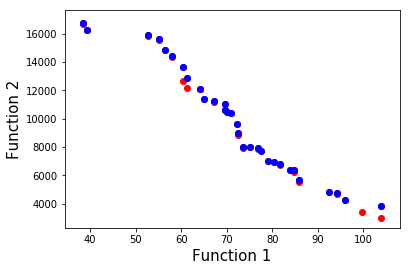

In [23]:
solution = nsgaii('Instancias/GKD-b_13_n50_b02_m5_k05.txt', 100, 50)

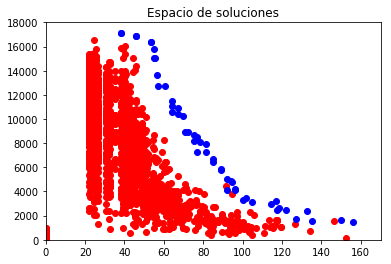

In [190]:
#SOLUCIONES RANDOM EN EL ESPACIO DE SOLUCIONES QUE CUMPLAN LA RESTRICCIÓN

data = pd.read_csv('Instancias/GKD-b_13_n50_b02_m5_k05.txt', skiprows=3, sep='\t', header=None, usecols=np.arange(50))

Cells_dist = data.loc[1:50,:].values
Cells_cap = data.loc[0].values
Cells_cost = data.loc[51,:].values
cost_max = data[0][52]

solution2=[]
while (len(solution2) != 2000):
    possible_solution = initial_solution(Cells_dist.shape[0])
    if (func_cost(possible_solution, Cells_cost) <= cost_max):
        solution2.append(list(possible_solution))

dist_values = [func_dist(solution[i], Cells_dist) for i in range(len(solution))]
cap_values = [func_cap(solution[i], Cells_cap) for i in range(len(solution))]        
        
dist_values2 = [func_dist(solution2[i], Cells_dist) for i in range(len(solution2))]
cap_values2 = [func_cap(solution2[i], Cells_cap) for i in range(len(solution2))]

# plt.xlabel('Function 1', fontsize=15)
# plt.ylabel('Function 2', fontsize=15)

plt.scatter(dist_values2, cap_values2, color = 'red')
plt.scatter(dist_values, cap_values, color = 'blue')
plt.title('Espacio de soluciones')
plt.xlim(0,170)
plt.ylim(0,18000)
plt.savefig('C:\\Users\\emili\\OneDrive\\Escritorio\\espacio.png')
plt.show()

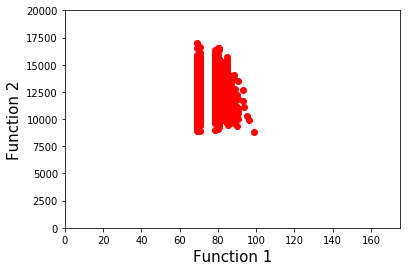

In [153]:
#SOLUCIONES RANDOM DEL ESPACIO DE SOLUCIONES QUE NO CUMPLAN LA RESTRICCIÓN

data = pd.read_csv('GKD-b_11_n50_b02_m5_k05.txt', skiprows=3, sep='\t', header=None, usecols=np.arange(50))

Cells_dist = data.loc[1:50,:].values
Cells_cap = data.loc[0].values
Cells_cost = data.loc[51,:].values
cost_max = data[0][52]

solution=[]
while (len(solution) != 4000):
    possible_solution = initial_solution(Cells_dist.shape[0])
    if (func_cost(possible_solution, Cells_cost) >= cost_max):
        solution.append(list(possible_solution))

dist_values = [func_dist(solution[i], Cells_dist) for i in range(len(solution))]
cap_values = [func_cap(solution[i], Cells_cap) for i in range(len(solution))]

plt.xlabel('Function 1', fontsize=15)
plt.ylabel('Function 2', fontsize=15)
plt.scatter(dist_values, cap_values, color = 'red')
plt.xlim(0,175)
plt.ylim(0,20000)
plt.show()

In [31]:
'Función extra para evaluar un conjunto de soluciones con la métrica HV'
def valorhv(data, solution):
    
    Cells_dist = data.loc[1:50,:].values
    Cells_cap = data.loc[0].values
    Cells_cost = data.loc[51,:].values
    cost_max = data[0][52]
    
    vector = []
    v = []
    dist_values = [-func_dist(solution[i], Cells_dist) for i in range(len(solution))]
    cap_values = [-func_cap(solution[i], Cells_cap) for i in range(len(solution))]
    for index in range(len(solution)):
        v = [dist_values[index], cap_values[index]]
        vector.append(v)
    vector = np.array(vector)
    
    hv = get_performance_indicator("hv", ref_point=np.array([0., 0.]))
    hv_value = hv.calc(vector)
#     print("hv", hv_value)
    return hv_value

In [ ]:
'Ejemplo para evaluar diferentes ejecuciones del algoritmo sobre una isntancia'
data = pd.read_csv('Instancias/GKD-b_11_n50_b02_m5_k05.txt', skiprows=3, sep='\t', header=None, usecols=np.arange(50))
hv_val = [[],[],[],[],[],[],[],[],[],[]]
for i in range(10):
    solution = nsgaii(data, 100, 50)
    hv = valorhv(data, solution[:20][:])
    hv_60_30[i].append(hv/(205*13800))
    print(hv_60_30[i])